In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Download and grab 

In [ ]:
def retrieve_data():
    file_url="https://www.ncei.noaa.gov/"
    path="data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/"
    filename="ibtracs.NA.list.v04r00.csv"
    print(f'{file_url}{path}{filename}')
    df = pd.read_csv(f'{file_url}{path}{filename}',
                    skiprows=[1],
                    header=0,
                    na_values=[" ", -999,-9999, 9999],
                    keep_default_na=False) # "NA"  is a legit basin we don't want pandas nan'ing it
    df = df.dropna(axis=1, how='all')
    return df

## Open Data and quick look

In [ ]:
df = retrieve_data()
df.describe()

https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/ibtracs.NA.list.v04r00.csv


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (21,128,148) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


SEASON         NUMBER  ...    STORM_SPEED      STORM_DIR
count  122629.000000  122629.000000  ...  122600.000000  122600.000000
mean     1941.009769      52.690930  ...      11.742080     190.723336
std        51.827205      27.913578  ...       7.578135     126.768856
min      1851.000000       1.000000  ...       0.000000       0.000000
25%      1891.000000      29.000000  ...       7.000000      52.000000
50%      1948.000000      51.000000  ...      10.000000     269.000000
75%      1988.000000      72.000000  ...      15.000000     300.000000
max      2021.000000     150.000000  ...     112.000000     360.000000

[8 rows x 49 columns]

## Some initial clean up and reformatting

In [ ]:
print(df['NATURE'].unique())
print(df['BASIN'].unique())

['TS' 'ET' 'SS' 'NR' 'MX' 'DS']
['NA' 'EP' 'NI']


1. Select rows where basin is 'NA' (North Atlantic)
2. Drop any columns (axis=1) where there are more less than 100 real values

In [ ]:
df = df.loc[(df['BASIN'] == 'NA'),:]  # make sure we only have N. Atl records
df = df.dropna(axis=1, thresh=100)  # drop empty columns

At the moment Pandas guess at what data type each column is, usually defaulting to string
1. Make sure wind values are numbers, and "coerce" non-numeric strings 
2. convert the string times, to datetime type

In [ ]:
df.loc[:, 'WMO_WIND'] = pd.to_numeric(df['WMO_WIND'], errors='coerce')
df.loc[:,'datetime'] = pd.to_datetime(df['ISO_TIME'])
print(df.head())
print(df.columns.tolist())

             SID  SEASON  NUMBER  ... STORM_SPEED STORM_DIR            datetime
0  1851175N26270    1851       5  ...         6.0     291.0 1851-06-23 12:00:00
1  1851175N26270    1851       5  ...         6.0     290.0 1851-06-23 15:00:00
2  1851175N26270    1851       5  ...         6.0     290.0 1851-06-23 18:00:00
3  1851175N26270    1851       5  ...         6.0     290.0 1851-06-23 21:00:00
4  1851175N26270    1851       5  ...         6.0     290.0 1851-06-24 00:00:00

[5 rows x 56 columns]
['SID', 'SEASON', 'NUMBER', 'BASIN', 'SUBBASIN', 'NAME', 'ISO_TIME', 'NATURE', 'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'WMO_AGENCY', 'TRACK_TYPE', 'DIST2LAND', 'LANDFALL', 'IFLAG', 'USA_AGENCY', 'USA_ATCF_ID', 'USA_LAT', 'USA_LON', 'USA_RECORD', 'USA_STATUS', 'USA_WIND', 'USA_PRES', 'USA_SSHS', 'USA_R34_NE', 'USA_R34_SE', 'USA_R34_SW', 'USA_R34_NW', 'USA_R50_NE', 'USA_R50_SE', 'USA_R50_SW', 'USA_R50_NW', 'USA_R64_NE', 'USA_R64_SE', 'USA_R64_SW', 'USA_R64_NW', 'USA_POCI', 'USA_ROCI', 'USA_RMW', 

Add a new column to the dataframne 

In [ ]:
df.loc[:,'ACE'] = (df.loc[:,'WMO_WIND'] ** 2)* (10 ** -4)

df.head()
df.describe()

SEASON         NUMBER  ...      STORM_DIR           ACE
count  122157.000000  122157.000000  ...  122128.000000  51453.000000
mean     1940.894955      52.588300  ...     190.543463      0.341966
std        51.856575      27.862124  ...     126.790977      0.328029
min      1851.000000       1.000000  ...       0.000000      0.010000
25%      1891.000000      29.000000  ...      52.000000      0.122500
50%      1948.000000      51.000000  ...     268.000000      0.250000
75%      1988.000000      72.000000  ...     300.000000      0.490000
max      2021.000000     150.000000  ...     360.000000      2.722500

[8 rows x 42 columns]

## Groupby operations

Groupy by Season column and sum all the other columns

-n.b. referencing columns with [column_name] is ok for reference but use `.loc` for subsets, and defining values. (Views vs Copies)

        NUMBER          LAT         LON  ...  STORM_SPEED  STORM_DIR       ACE
SEASON                                   ...                                  
1851      8711  17426.02280 -46848.1908  ...       5409.0   106200.0   38.1300
1852      5489  15317.48460 -40965.5097  ...       7473.0   121097.0   74.0900
1853      6852  16723.30330 -39953.6249  ...       6977.0   124924.0   79.9000
1854      6003  14221.83990 -36248.9402  ...       5362.0    94783.0   32.8100
1855      6102  14709.00170 -31041.8721  ...       3001.0    93298.0   19.3300
...        ...          ...         ...  ...          ...        ...       ...
2017     61263  22113.42188 -57592.2767  ...       9700.0   186430.0  254.1525
2018     53790  18593.62938 -38814.4692  ...       8113.0   156057.0  135.1900
2019     41375  16606.56590 -38384.6295  ...       7288.0   129253.0  144.2575
2020     83239  29682.85546 -84393.6111  ...      14109.0   269781.0    0.0000
2021       174    217.65350   -358.5631  ...        

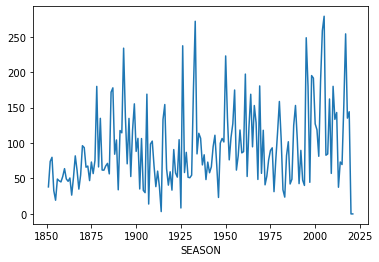

In [ ]:
seasonal_sum = df[(df['NATURE'] == 'TS')].groupby('SEASON').sum()
print(seasonal_sum)

seasonal_sum['ACE'].plot()
plt.show()


Calculate phase speed for all timesteps:
so we want distance / time per row per storm

Can apply diff per storm_id on lat/lon/time then calculate the phase speed for each row.  

We'll use crudge trig for lat/lon distance here but could also apply haversine etc.


Subselect columns and apply `diff` operation per storm id

In [ ]:
storm_diffs = df.loc[:, ['SID', 'LAT', 'LON', 'datetime']].groupby('SID').diff()
print(storm_diffs.describe())             

                 LAT            LON                   datetime
count  119885.000000  119885.000000                     119885
mean        0.282768       0.019960  0 days 02:58:54.537264878
std         0.334690       0.672888  0 days 00:11:07.853170528
min        -3.570600      -5.319000            0 days 00:05:00
25%         0.088400      -0.442600            0 days 03:00:00
50%         0.234800      -0.107500            0 days 03:00:00
75%         0.428900       0.322300            0 days 03:00:00
max         4.616300       6.270100            0 days 21:00:00


Convert those lat/lon diffs to km 
(yes this is inaccurate but close enough for this)

In [ ]:
storm_diff_km = np.sqrt((storm_diffs['LAT'])**2 + (storm_diffs['LON'])**2) * 111. * np.cos(np.degrees(df['LAT']))
print(storm_diff_km.describe())

count    119885.000000
mean         -0.296346
std          62.909646
min        -658.971864
25%         -35.182840
50%          -0.273950
75%          34.843470
max         571.772437
dtype: float64


Because the datetime column was a datetime type, the diff is now a `timedelta` type.  To access datetime or timedelta attributes use the `.dt` accessor.  

We can convert the `timedelta` Series to the equivalent seconds as below

In [ ]:
print(storm_diffs['datetime'].dt.total_seconds().describe())

count    119885.000000
mean      10734.537265
std         667.853171
min         300.000000
25%       10800.000000
50%       10800.000000
75%       10800.000000
max       75600.000000
Name: datetime, dtype: float64


And using the same logic, convert those seconds to hours

In [ ]:
storm_diff_hours = (storm_diffs['datetime'].dt.total_seconds()/(60*60))
print(storm_diff_hours.describe())

count    119885.000000
mean          2.981816
std           0.185515
min           0.083333
25%           3.000000
50%           3.000000
75%           3.000000
max          21.000000
Name: datetime, dtype: float64


Now create new series (speed) from our calculations.  

This could all be done within the 1 dataframe, exploded here to highlight the steps

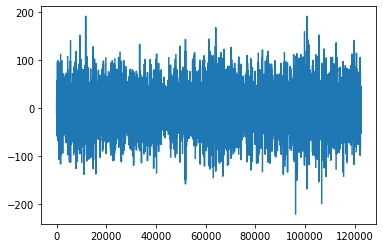

In [ ]:
speed  = storm_diff_km / storm_diff_hours
speed.plot()
plt.show()

All our calculations above maintained the index of the dataframe so we can drop the data back into the original data where it should go. 

           NUMBER        LAT        LON  ...       ACE     speed  abs_speed
SEASON                                   ...                               
1851    13.401538  26.809266 -72.074140  ...  0.389082 -0.739788  11.344811
1852     8.983633  25.069533 -67.046661  ...  0.552910  1.606730  15.894085
1853    11.069467  27.016645 -64.545436  ...  0.753774 -0.800381  15.071519
1854    11.075646  26.239557 -66.879963  ...  0.546833 -0.288404  12.724498
1855    12.179641  29.359285 -61.959825  ...  0.552286 -0.535929   7.933282
...           ...        ...        ...  ...       ...       ...        ...
2017    69.145598  24.958715 -65.002570  ...  0.552505 -0.738860  13.991687
2018    74.090909  25.611060 -53.463456  ...  0.365378  0.935442  13.610287
2019    64.851097  26.029100 -60.163996  ...  0.437144 -0.220642  14.337366
2020    66.966211  23.880012 -67.895101  ...       NaN -0.679074  14.212523
2021    29.000000  36.275583 -59.760517  ...       NaN -0.465772  15.175567

[171 rows x

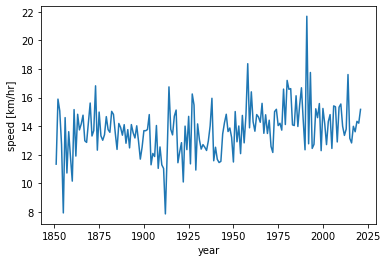

In [ ]:
df.loc[:, 'speed'] = speed
df.loc[:, 'abs_speed'] = speed.abs()
df.loc[:, 'abs_speed'] = df.loc[:, 'abs_speed'].where(df['abs_speed']<250, np.nan)


seasonal_sum = df[(df['NATURE'] == 'TS')].groupby('SEASON').mean()
print(seasonal_sum)

ax = seasonal_sum['abs_speed'].plot()
ax.set_xlabel('year')
ax.set_ylabel('speed [km/hr]')
plt.show()

Seaborn is a nice addition to plotting libraries for visualising things.  

Lots of options for another day, but dropping data into the routines is very simple

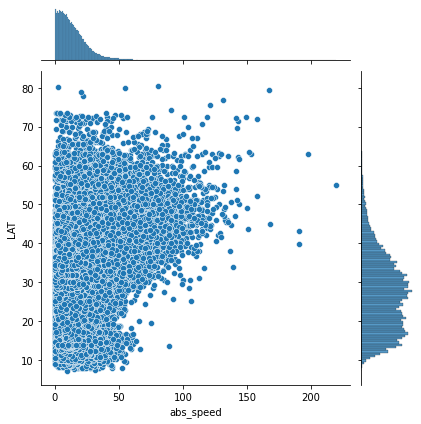

In [ ]:
sns.jointplot(x=df['abs_speed'], y=df['LAT'])

## Let's work out how long the storms live, then plot speed based on lifetime

define a custom function to operate on each group

In [ ]:
def remaining_lifetime(df):
    return (df['datetime'].max()-df['datetime']).astype('timedelta64[h]')

lifetime = df.groupby('SID').apply(remaining_lifetime)
print(lifetime)

SID                  
1851175N26270  0         108.0
               1         105.0
               2         102.0
               3          99.0
               4          96.0
                         ...  
2021139N30302  122624     12.0
               122625      9.0
               122626      6.0
               122627      3.0
               122628      0.0
Name: datetime, Length: 122157, dtype: float64


The groupby operation gives lifetime a new multiindex, we can reset_index() or just take the values ignoring the index (assuming the rows were in order; risky)

                  SID  SEASON  NUMBER  ...      speed  abs_speed lifetime
0       1851175N26270    1851       5  ...        NaN        NaN    108.0
1       1851175N26270    1851       5  ...  10.115971  10.115971    105.0
2       1851175N26270    1851       5  ...   5.459280   5.459280    102.0
3       1851175N26270    1851       5  ...  -0.865368   0.865368     99.0
4       1851175N26270    1851       5  ...  -6.814991   6.814991     96.0
...               ...     ...     ...  ...        ...        ...      ...
122624  2021139N30302    2021      29  ...   7.474080   7.474080     12.0
122625  2021139N30302    2021      29  ... -18.070283  18.070283      9.0
122626  2021139N30302    2021      29  ... -28.853736  28.853736      6.0
122627  2021139N30302    2021      29  ...  10.976340  10.976340      3.0
122628  2021139N30302    2021      29  ...  43.578670  43.578670      0.0

[122157 rows x 60 columns]


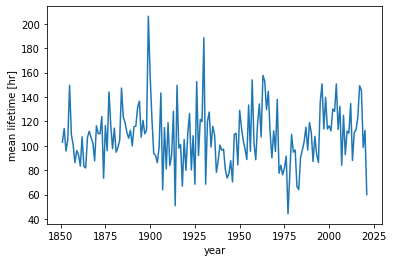

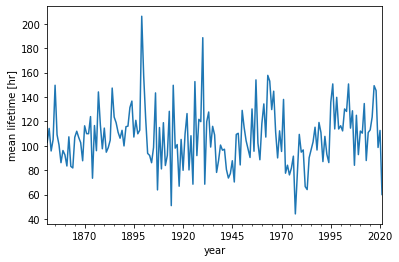

In [ ]:
df.loc[:,'lifetime'] = lifetime.values
print(df)

seasonal_mean = df.groupby('SEASON').mean()
annual_mean = df.set_index('datetime').resample('1Y').mean()

ax = seasonal_mean['lifetime'].plot()
ax.set_xlabel('year')
ax.set_ylabel('mean lifetime [hr]')
plt.show()

ax2 = annual_mean['lifetime'].plot()
ax2.set_xlabel('year')
ax2.set_ylabel('mean lifetime [hr]')
plt.show()



Set the index of the dataframe to be the datetime column, then we use that for some extra features 

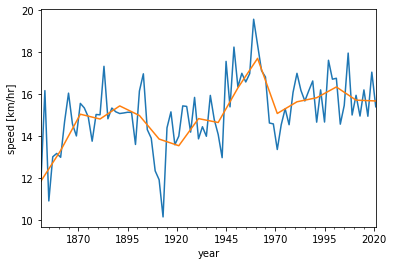

In [ ]:
dfdt = df.set_index('datetime')

ann2_mean = dfdt.resample('2Y').mean()
ann10_mean = dfdt.resample('10Y').mean()
ax = ann2_mean['abs_speed'].plot()
ann10_mean['abs_speed'].plot(ax=ax)
ax.set_xlabel('year')
ax.set_ylabel('speed [km/hr]')
plt.show()


In [ ]:
age_threshold = 72

Subselect rows and also apply the 2y running mean operation. 

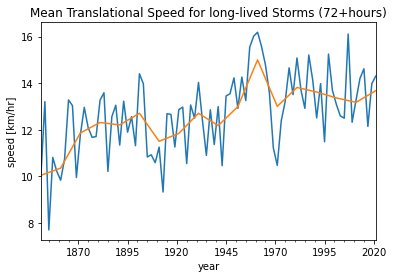

In [ ]:
ann2_mean = dfdt[dfdt['lifetime']>age_threshold].resample('2Y').mean()
ann10_mean = dfdt[dfdt['lifetime']>age_threshold].resample('10Y').mean()


ax = ann2_mean['abs_speed'].plot()
ann10_mean['abs_speed'].plot(ax=ax)
ax.set_title(f'Mean Translational Speed for long-lived Storms ({age_threshold}+hours)')
ax.set_xlabel('year')
ax.set_ylabel('speed [km/hr]')
plt.show()

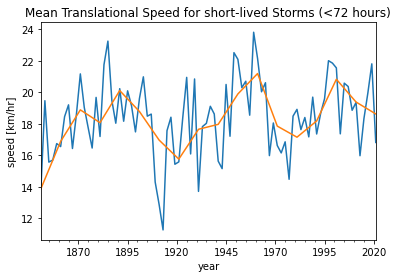

In [ ]:
ann2_mean = dfdt[dfdt['lifetime']<=age_threshold].resample('2Y').mean()
ann10_mean = dfdt[dfdt['lifetime']<=age_threshold].resample('10Y').mean()


ax = ann2_mean['abs_speed'].plot()
ann10_mean['abs_speed'].plot(ax=ax)
ax.set_title(f'Mean Translational Speed for short-lived Storms (<{age_threshold} hours)')
ax.set_xlabel('year')
ax.set_ylabel('speed [km/hr]')
plt.show()

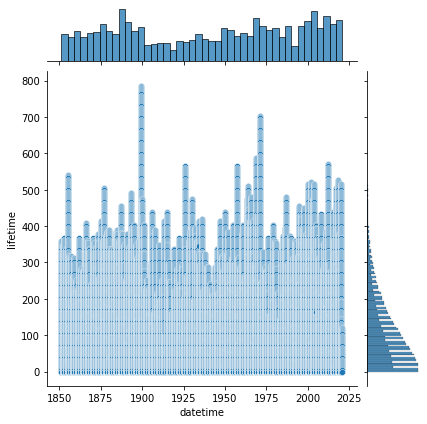

In [ ]:
sns.jointplot(x=dfdt.index.year, y=dfdt['lifetime'])

# Dig into data to find specific events (date of 7th genesis per year)

In [ ]:
for year, anngroup in df.groupby('SEASON'):
    print(year, anngroup.shape)

1851 (669, 60)
1852 (639, 60)
1853 (651, 60)
1854 (569, 60)
1855 (515, 60)
1856 (548, 60)
1857 (682, 60)
1858 (556, 60)
1859 (761, 60)
1860 (819, 60)
1861 (788, 60)
1862 (535, 60)
1863 (550, 60)
1864 (459, 60)
1865 (624, 60)
1866 (649, 60)
1867 (764, 60)
1868 (486, 60)
1869 (521, 60)
1870 (944, 60)
1871 (995, 60)
1872 (643, 60)
1873 (579, 60)
1874 (522, 60)
1875 (528, 60)
1876 (753, 60)
1877 (808, 60)
1878 (1454, 60)
1879 (881, 60)
1880 (1043, 60)
1881 (900, 60)
1882 (581, 60)
1883 (607, 60)
1884 (645, 60)
1885 (746, 60)
1886 (1075, 60)
1887 (1907, 60)
1888 (934, 60)
1889 (1081, 60)
1890 (392, 60)
1891 (1015, 60)
1892 (998, 60)
1893 (1288, 60)
1894 (703, 60)
1895 (833, 60)
1896 (735, 60)
1897 (560, 60)
1898 (1064, 60)
1899 (728, 60)
1900 (596, 60)
1901 (913, 60)
1902 (304, 60)
1903 (591, 60)
1904 (337, 60)
1905 (271, 60)
1906 (848, 60)
1907 (198, 60)
1908 (570, 60)
1909 (608, 60)
1910 (344, 60)
1911 (335, 60)
1912 (399, 60)
1913 (353, 60)
1914 (36, 60)
1915 (474, 60)
1916 (824, 60)
191

In [ ]:
def get_genesis_times(annual_group):
    genesis_times = {}
    for storm_id, storm_data in annual_group.groupby('SID'):
        ts_data = storm_data.loc[storm_data['WMO_WIND']>=34]
        if ts_data.empty:
            continue
        genesis_times[storm_id] = ts_data['datetime'].iloc[0]
    return pd.Series(genesis_times)

More hands on with the groupby operator

iterate over each group and extract data into a list

In [ ]:
df = df.reset_index()

genesis_list = []
storm_number = 7
for year, annual_group in df.groupby('SEASON'):
    genesis_times = get_genesis_times(annual_group)
    if len(genesis_times) >= storm_number:
        genesis_times.sort_values(inplace=True)
        genesis_list.append({'year':year, 'time': genesis_times.iloc[storm_number-1], 'storm_id': genesis_times.index[storm_number-1]})

for entry in genesis_list[:10]:
    print(entry)


{'year': 1853, 'time': Timestamp('1853-09-26 00:00:00'), 'storm_id': '1853269N26298'}
{'year': 1859, 'time': Timestamp('1859-10-16 00:00:00'), 'storm_id': '1859289N25285'}
{'year': 1860, 'time': Timestamp('1860-10-20 00:00:00'), 'storm_id': '1860289N14290'}
{'year': 1861, 'time': Timestamp('1861-10-07 12:00:00'), 'storm_id': '1861281N35285'}
{'year': 1863, 'time': Timestamp('1863-09-18 12:00:00'), 'storm_id': '1863262N23264'}
{'year': 1865, 'time': Timestamp('1865-10-18 00:00:00'), 'storm_id': '1865287N11303'}
{'year': 1866, 'time': Timestamp('1866-10-29 06:00:00'), 'storm_id': '1866302N33285'}
{'year': 1867, 'time': Timestamp('1867-10-02 00:00:00'), 'storm_id': '1867268N18278'}
{'year': 1869, 'time': Timestamp('1869-09-11 00:00:00'), 'storm_id': '1869253N10328'}
{'year': 1870, 'time': Timestamp('1870-10-05 00:00:00'), 'storm_id': '1870278N18286'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


It's better to create a dict or list of values then form a single dataframe at the end, compared to appending rows on each loop.  append on the dataframe is very expensive as it copies the whole dataframe each time

In [ ]:
genesis_df = pd.DataFrame(genesis_list)
print(genesis_df)

     year                time       storm_id
0    1853 1853-09-26 00:00:00  1853269N26298
1    1859 1859-10-16 00:00:00  1859289N25285
2    1860 1860-10-20 00:00:00  1860289N14290
3    1861 1861-10-07 12:00:00  1861281N35285
4    1863 1863-09-18 12:00:00  1863262N23264
..    ...                 ...            ...
120  2015 2015-09-05 18:00:00  2015248N12337
121  2016 2016-08-22 18:00:00  2016235N11341
122  2017 2017-08-13 00:00:00  2017224N22293
123  2018 2018-09-03 09:00:00  2018246N22283
124  2019 2019-09-04 00:00:00  2019246N16330

[125 rows x 3 columns]


In [ ]:
genesis_df.loc[:,'day_of_year'] = genesis_df['time'].dt.dayofyear
genesis_df.sort_values(by='day_of_year')

year                time       storm_id  day_of_year
110  2005 2005-07-24 06:00:00  2005205N19267          205
100  1995 1995-08-10 12:00:00  1995222N24265          222
47   1936 1936-08-09 12:00:00  1936221N27272          222
122  2017 2017-08-13 00:00:00  2017224N22293          225
116  2011 2011-08-14 06:00:00  2011225N26302          226
..    ...                 ...            ...          ...
99   1994 1994-11-10 18:00:00  1994313N12278          314
35   1912 1912-11-11 06:00:00  1912316N11280          316
37   1921 1921-11-20 06:00:00  1921323N21295          324
71   1962 1962-11-26 12:00:00  1962331N33287          330
26   1896 1896-11-27 00:00:00  1896332N11299          332

[125 rows x 4 columns]